In [38]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib.cm as cm
from tqdm import tqdm
from utils import anisotropic_kernel
from sklearn.gaussian_process import GaussianProcessRegressor

In [75]:
lat = np.random.random(80)
lng = np.random.random(80)
elec = np.random.randn(80) * 0.2 + 0.5
true = elec + np.random.randn(80)j
elec[elec < 0] = 0
elec[elec > 1] = 1

In [76]:
df = pd.DataFrame({"lat": lat, "lng": lng, "elec": elec - np.mean(elec), "true": true})

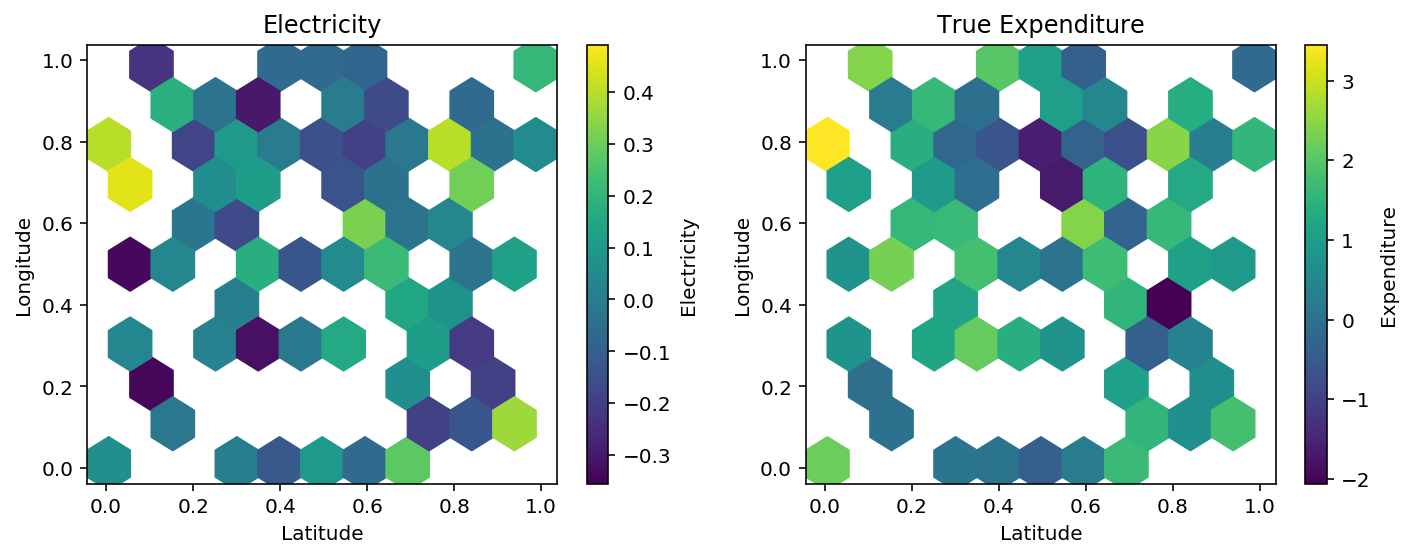

In [84]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
vmin = np.min(np.r_[df["elec"], df["elec"]])
vmax = np.max(np.r_[df["elec"], df["elec"]])
plt.hexbin(df["lng"], df["lat"], C=df["elec"], gridsize=10, cmap=cm.viridis, vmax=vmax, vmin=vmin, mincnt=0)
cb = plt.colorbar()
cb.set_label("Electricity")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Electricity")
plt.subplot(1,2,2)
vmin = np.min(np.r_[df["true"], df["true"]])
vmax = np.max(np.r_[df["true"], df["true"]])
plt.hexbin(df["lng"], df["lat"], C=df["true"], gridsize=10, cmap=cm.viridis, vmax=vmax, vmin=vmin, mincnt=0)
cb = plt.colorbar()
cb.set_label("Expenditure")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("True Expenditure")
plt.tight_layout()

In [355]:
def plot_predictions(preds, sds, idxs): 
  plt.figure(figsize=(15, 4))
  plt.subplot(1,3,1)
  vmin = np.min(np.r_[df["elec"], df["elec"], preds])
  vmax = np.max(np.r_[df["elec"], df["elec"], preds])
  plt.hexbin(df["lng"], df["lat"], C=preds, 
             gridsize=10, cmap=cm.viridis, vmax=vmax, vmin=vmin, mincnt=0)
  cb = plt.colorbar()
  cb.set_label("Expenditure")
  plt.xlabel("Latitude")
  plt.ylabel("Longitude")
  plt.title("Predictions")
  plt.subplot(1,3,2)
  plt.hexbin(df["lng"], df["lat"], C=sds, 
             gridsize=10, cmap=cm.viridis, vmax=0, vmin=np.max(sds), mincnt=0)
  cb = plt.colorbar()
  cb.set_label("SD")
  plt.xlabel("Latitude")
  plt.ylabel("Longitude")
  plt.title("SD of predictions")
  plt.subplot(1,3,3)
  vmin = np.min(np.r_[df["true"], df["true"], preds])
  vmax = np.max(np.r_[df["true"], df["true"], preds])
  plt.hexbin(df.iloc[idxs]["lng"], df.iloc[idxs]["lat"], C=df.iloc[idxs]["true"], 
             gridsize=10, cmap=cm.viridis, vmax=vmax, vmin=vmin, mincnt=0)
  cb = plt.colorbar()
  cb.set_label("Expenditure")
  plt.xlabel("Latitude")
  plt.ylabel("Longitude")
  plt.xlim((0, 1))
  plt.ylim((0, 1))
  plt.title("Sampled Expenditure")
  plt.tight_layout()

In [226]:
def plot_idxs(idxs): 
  plt.figure(figsize=(10, 4))
  plt.subplot(1,2,1)
  vmin = np.min(np.r_[df["elec"], df["elec"]])
  vmax = np.max(np.r_[df["elec"], df["elec"]])
  plt.hexbin(df.iloc[idxs]["lng"], df.iloc[idxs]["lat"], C=df.iloc[idxs]["elec"], 
             gridsize=10, cmap=cm.viridis, vmax=vmax, vmin=vmin, mincnt=0)
  cb = plt.colorbar()
  cb.set_label("Expenditure")
  plt.xlabel("Latitude")
  plt.ylabel("Longitude")
  plt.title("Electricity")
  plt.subplot(1,2,2)
  vmin = np.min(np.r_[df["true"], df["true"]])
  vmax = np.max(np.r_[df["true"], df["true"]])
  plt.hexbin(df.iloc[idxs]["lng"], df.iloc[idxs]["lat"], C=df.iloc[idxs]["true"], 
             gridsize=10, cmap=cm.viridis, vmax=vmax, vmin=vmin, mincnt=0)
  cb = plt.colorbar()
  cb.set_label("Expenditure")
  plt.xlabel("Latitude")
  plt.ylabel("Longitude")
  plt.title("True Expenditure")
  plt.tight_layout()

In [ ]:
plot_idxs([0, 2, 3, 4, 5, 6])

In [85]:
true_beta = pearsonr(true, elec)[0]
print("True: %.4f" % true_beta)

True: 0.2926


In [101]:
from utils import coeff_est_kernel

In [267]:
idxs = [0]
sampled_betas = []

In [268]:
for _ in tqdm(range(1, 80)):
  df_sampled = df.iloc[df.index.isin(idxs),:]
  df_rest = df.iloc[~df.index.isin(idxs),:]
  sampled_betas.append(pearsonr(df_sampled["elec"], df_sampled["true"])[0])
  idx = np.random.choice(df_rest.index)
  idxs.append(idx)

  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
100%|██████████| 79/79 [00:00<00:00, 321.29it/s]


In [269]:
ses = np.sqrt((1 - np.array(sampled_betas)) / (np.arange(len(sampled_betas)) - 2))

/home/tony/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/tony/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Random sampling')

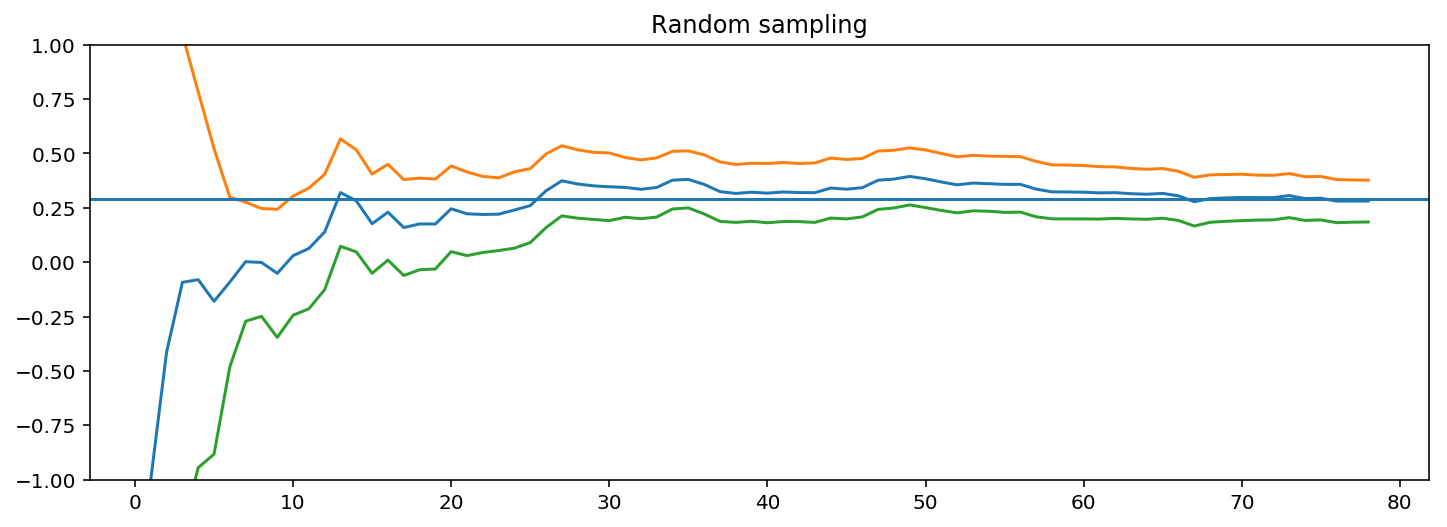

In [390]:
plt.figure(figsize=(12, 4))
plt.plot(sampled_betas)
plt.plot(sampled_betas + ses)
plt.plot(sampled_betas - ses)
plt.ylim((-1, 1))
plt.axhline(y=true_beta)
plt.title("Random sampling")

In [352]:
idxs = [0]
sampled_betas = []
gps = []

In [353]:
for _ in tqdm(range(1, 80)):
  df_sampled = df.iloc[df.index.isin(idxs),:]
  df_rest = df.iloc[~df.index.isin(idxs),:]
  sampled_betas.append(pearsonr(df_sampled["elec"], df_sampled["true"])[0])
  gp = GaussianProcessRegressor(kernel=coeff_est_kernel, normalize_y=True)
  gp.fit(df_sampled.loc[:,("lat", "lng", "elec")], df_sampled["true"])
  preds = gp.sample_y(df.loc[:, ("lat", "lng", "elec")], n_samples = 10)
  idx = df.index[np.argmax(np.std(preds, axis=1))]
  idxs.append(idx)
  gps.append(gp)

  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
100%|██████████| 79/79 [00:16<00:00,  4.92it/s]


In [363]:
df.iloc[78]

elec   -0.337160
lat     0.447228
lng     0.041701
true    0.778989
Name: 78, dtype: float64

In [370]:
idxs[6]

78

In [375]:
np.argmax(np.std(gps[4].sample_y(df.loc[:, ("lat", "lng", "elec")], n_samples=10), axis=1))

79

In [378]:
df.iloc[79]

elec    0.209118
lat     0.960367
lng     0.987795
true   -0.177000
Name: 79, dtype: float64

In [379]:
idxs[:6]

[0, 8, 63, 75, 66, 79]

In [380]:
df.iloc[idxs[:6]]

,elec,lat,lng,true
0,0.126894,0.504425,0.929332,0.924391
8,-0.228773,0.978573,0.127715,2.419903
63,0.490277,0.299285,0.524267,1.789369
75,0.034344,0.847717,0.667888,-0.137067
66,0.018140,0.471864,0.871738,1.092298
79,0.209118,0.960367,0.987795,-0.177000


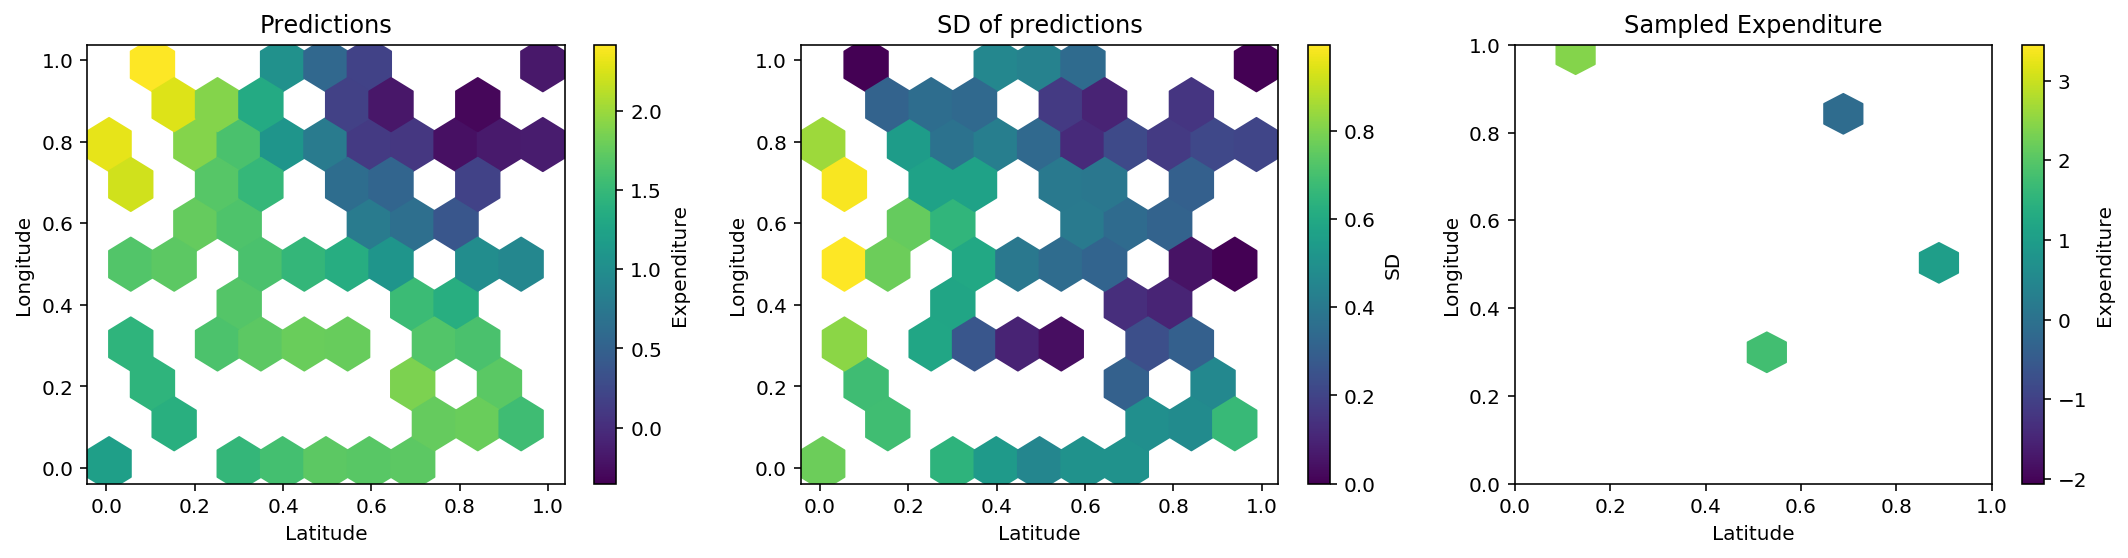

In [389]:
plot_predictions(gps[5].predict(df.loc[:, ("lat", "lng", "elec")]),
                 np.std(gps[5].sample_y(df.loc[:, ("lat", "lng", "elec")], n_samples=10), axis=1),
                 idxs[:5])

In [382]:
gps[4].kernel_

0.958**2 * SubspaceRBF(length_scale=0.28) + 0.00316**2 * SubspaceDot(sigma_0=0.001)

In [383]:
gps[5].kernel_

1.03**2 * SubspaceRBF(length_scale=0.355) + 0.00316**2 * SubspaceDot(sigma_0=0.00129)

In [274]:
coeff_est_kernel = ConstantKernel() * SubspaceRBF(dims=np.array([0, 1]), length_scale_bounds=(1e-2, 1e2)) + \
                   ConstantKernel() * SubspaceDot(dims=np.array([2]), sigma_0_bounds = (1e-3, 1e3))

In [262]:
ses = np.sqrt((1 - np.array(sampled_betas)) / (np.arange(len(sampled_betas)) - 2))

/home/tony/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/tony/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


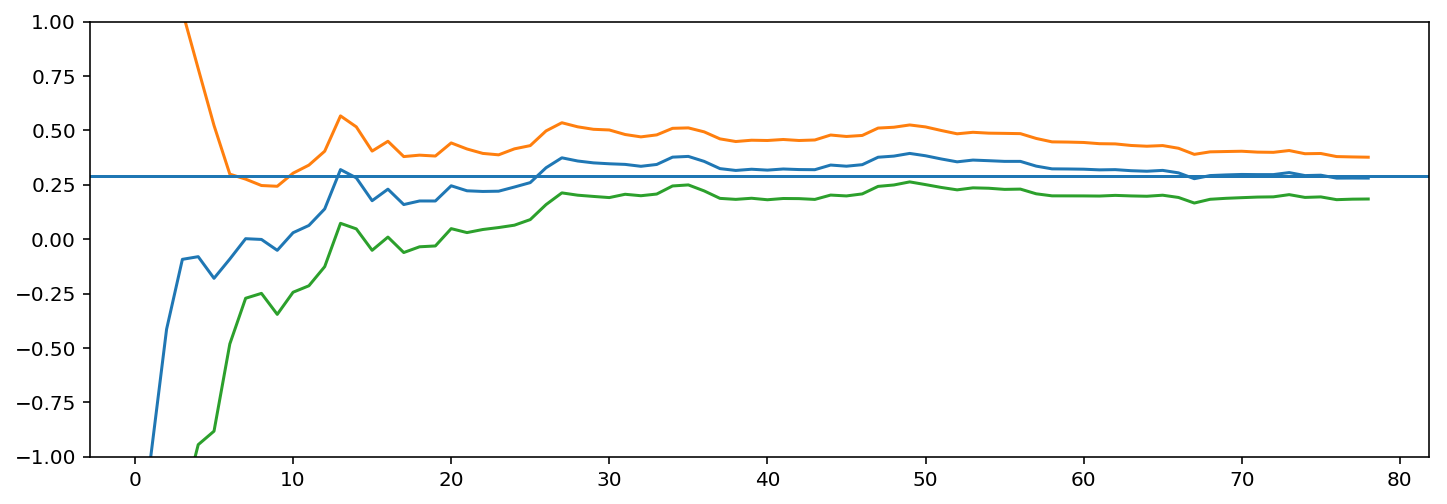

In [386]:
plt.figure(figsize=(12, 4))
plt.plot(sampled_betas)
plt.plot(sampled_betas + ses)
plt.plot(sampled_betas - ses)
plt.ylim((-1, 1))
plt.axhline(y=true_beta)